In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import torch
import matplotlib.pyplot as plt

from numpy import pi, inf, exp
from torch import sin
from torch.autograd import grad

In [91]:
def torch_nth_derivative(f, x, n):
    """Compute n-th order derivative of a function f: R -> R at the 
    points x in R.
    """
    if x.requires_grad:
        detach = False
    else:
        detach = True
        x.requires_grad = True
    
    g = f(x).sum()
    dx = f(x)

    for i in range(n):
        dx = grad(g, x, create_graph=True)[0]
        g = dx.sum()
        
    if detach:
        x.requires_grad = False
        return dx.detach()
    
    return dx

class SineVectorField:
    def __init__(self, weights):
        self.d = weights.numel()
        self.N = torch.arange(1, self.d+1, dtype=torch.float32)
        self.weights = weights.float()
        
    def __call__(self, x):
        return (self.weights * torch.sin(pi * self.N * x) / (pi * self.N)).sum(dim=-1, keepdims=True)

    
class ComposedVectorfield:
    def __init__(self, vector_field_collection):
        self.collection = vector_field_collection
        
    def __call__(self, x):
        y = x
        for fl in self.collection:
            y = y + fl(y)
        return y - x
    
    def get_weight_matrix(self):
        return torch.stack([fi.weights for fi in self.collection])

def approx_max_norm(f, k, npoints=int(1e4)):
    xx = torch.linspace(0, 1, npoints).view(-1, 1)
    df = torch_nth_derivative(f, xx, n=k)
    return torch.abs(df).max()

def one_hot(i, N):
    vec = torch.zeros(N)
    vec[i] = 1.
    return vec

def scale_weights_loose_common(W, k):
    L, d = W.shape
    N = torch.arange(1, d+1) 
    
    scalar = (torch.abs(W) * (N * pi)**(k-1)).sum()
    if scalar >= 1 - 1e-8:
        W *= (1-1e-8) / scalar
        
    return W

def scale_weights_loose_separate(W, k):
    L, d = W.shape
    N = torch.arange(1, d+1)
    
    for wi in W:
        scalar = (torch.abs(wi) * (N * pi)**(k-1)).sum()
        if scalar >= 1. / L - 1e-8:
            wi *= (1./L - 1e-8) / scalar
    
    return W

def scale_weights_tight_common(W, k):
    L, d = W.shape
    N = torch.arange(1, d+1)
    
    # Create vector field collection
    F = ComposedVectorfield([SineVectorField(wi) for wi in W])
    
    # Compute the sum of the C^k-norms for the different vector fields
    scalar = torch.stack([approx_max_norm(fi, k=k) for fi in F.collection])
    scalar = float(scalar.sum())
    if scalar >= 1 - 1e-8:
        W *= (1-1e-8) / scalar
    
    return W

def scale_weights_tight_separate(W, k):
    L, d = W.shape
    N = torch.arange(1, d+1)
    
    # Compute the sum of the C^k-norms for the different vector fields
    for wi in W:
        scalar = approx_max_norm(SineVectorField(wi), k=k)
        if scalar >= 1. / L - 1e-8:
            wi *= (1./L - 1e-8) / scalar
    
    return W

def create_weights_ones(L, d):
    return torch.ones(L, d)


def create_weights_sample_uniform(L, d):
    return torch.rand(L, d)


def build_weights_sample_normal(mean, std):    
    def create_weights_sample_normal(L, d):
        return mean + std * torch.randn(L, d)
    return create_weights_sample_normal


def compute_bound_practical(L, d, k, weight_creation, weight_projection):
    W = weight_creation(L, d)
    W = weight_projection(W, k)
    
    F = ComposedVectorfield([SineVectorField(torch.clone(wi)) for wi in W])
    field_sum = torch.stack([approx_max_norm(fi, k=k) for fi in F.collection])
    field_sum = float(field_sum.sum())    
    return approx_max_norm(F, k) / (exp(k) * field_sum)


def reduce_compute_bound_practical(weight_creation, weight_projection):
    def f(L, d, k):
        return compute_bound_practical(L, d, k, weight_creation, weight_projection)
    return f

## Weight: Ones, Projection: Separate Loose

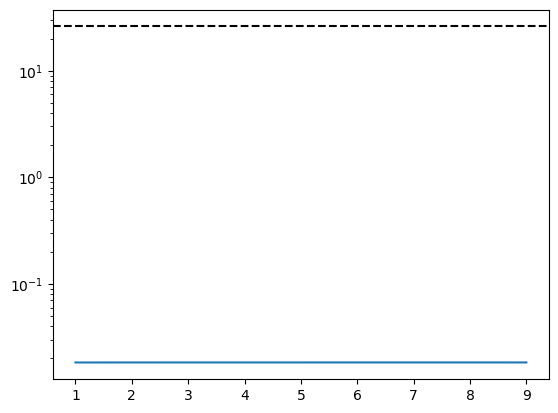

In [105]:
k = 4
d = 6
M = Mk[k-1]

values = [compute_bound_practical(l, d, k, create_weights_ones, scale_weights_tight_common) for l in range(1, 10)]
    
plt.figure()
plt.semilogy(range(1, 10), values)
plt.axhline(M, c='k', ls='--')
plt.show()

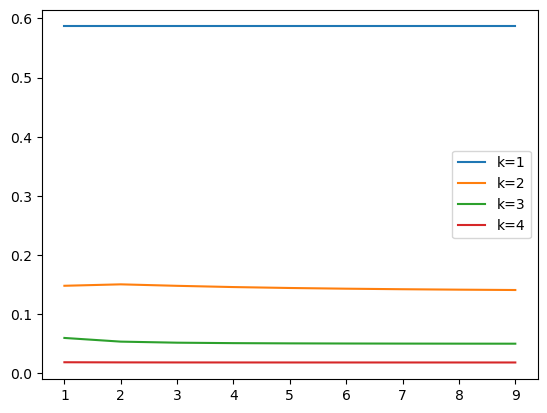

In [106]:
k = 0
d = 6
L = 10
M = Mk[k-1]


plt.figure()

for k in range(1, 5):
    values = [compute_bound_practical(L, d, k, create_weights_ones, scale_weights_tight_common) for d in range(1, 10)]
    plt.plot(range(1, 10), values, label=f'k={k}')
# plt.axhline(M, c='k', ls='--')
plt.legend()
plt.show()

In [117]:
torch.tensor(ones_tightcommon) - torch.tensor(uniform_tightcommon)

tensor([ 1.5872e-02,  9.2308e-04,  8.2121e-05,  9.0582e-05, -5.0884e-07,
         6.4151e-06, -1.0871e-10,  4.6449e-08,  0.0000e+00],
       dtype=torch.float64)

In [ ]:
L = 3
d = 5
Mk = torch.tensor([
    1, 1, 4, 26, 236, 2752, 39208, 660032, 12818912
])
k_max = len(Mk)
kvec = torch.arange(1, k_max+1)

ones_tightcommon = [compute_bound_practical(L, d, ki, torch.ones, scale_weights_tight_common)for ki in kvec]
uniform_tightcommon = [compute_bound_practical(L, d, ki, torch.rand, scale_weights_tight_common) for ki in kvec]
normal_tightcommon = [compute_bound_practical(L, d, ki, build_weights_sample_normal(0., 1.), scale_weights_tight_common) for ki in kvec]


plt.figure()
plt.semilogy(kvec, ones_tightcommon, label="1")
plt.semilogy(kvec, uniform_tightcommon, label="$\mathcal{U}$")
plt.semilogy(kvec, normal_tightcommon, label="$\mathcal{N}$")
plt.legend()
plt.show()